In [1]:
import sys, os
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('your@email.com')

In [2]:
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


In [3]:
def length_to_windows(length_df, pops, window_size=1000000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [4]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"

In [5]:
input_file = rfmix_path + "all_chrX.msp.tsv"
chrX = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [6]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [7]:
df_l = []
for hap in chrX.columns[6:]:
    df_l.append(create_paint_df_ind(chrX, hap, number_subpop_mapping, north_south_mapping))
length_df_X = pd.concat(df_l)

In [8]:
sampling_locations_c = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].C_origin.unique()
sampling_locations_o = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].Origin.unique()


In [10]:
location_l = []
for sampling_location in sampling_locations_c:
    samples = meta_data_samples.loc[(meta_data_samples.C_origin == sampling_location)].PGDP_ID
    s_df = length_df_X.loc[length_df_X.individual.isin(samples)]
    s_df = s_df.groupby(["pos"])[["n/s", "length"]].mean().reset_index()
    s_df["Origin"] = sampling_location
    #s_df["C_origin"] = sampling_locations_c
    
    location_l.append(s_df)
location_df_X = pd.concat(location_l)

In [11]:
location_df_X.to_csv(rfmix_path + "chrX_summary_df.txt")

In [12]:
location_df_X

,pos,n/s,length,Origin
0,2500194,0.0,20174.0,"Cynocephalus, Central Tanzania"
1,2520368,0.0,18700.0,"Cynocephalus, Central Tanzania"
2,2539068,0.0,34526.0,"Cynocephalus, Central Tanzania"
3,2573594,0.0,1336.0,"Cynocephalus, Central Tanzania"
4,2574930,0.0,14436.0,"Cynocephalus, Central Tanzania"
...,...,...,...,...
7283,143085438,1.0,4621.0,"Anubis, Ethiopia"
7284,143090059,1.0,12501.0,"Anubis, Ethiopia"
7285,143102560,1.0,124649.0,"Anubis, Ethiopia"
7286,143227209,1.0,411301.0,"Anubis, Ethiopia"


In [13]:
loc_df = location_df_X
olive_tanzania = loc_df.loc[loc_df.Origin == "Anubis, Tanzania"]
eastern_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Central Tanzania"]
western_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Western Tanzania"]

In [14]:
# USed when clustering by Origin instead of C_origin
loc_df = location_df_X

serengeti = loc_df.loc[loc_df.Origin == "Serengeti, Tanzania"]
tarangire = loc_df.loc[loc_df.Origin == "Tarangire, Tanzania"]
gog = loc_df.loc[loc_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = loc_df.loc[loc_df.Origin == "Gombe, Tanzania"]
mikumi = loc_df.loc[loc_df.Origin == "Mikumi, Tanzania"]
ruaha = loc_df.loc[loc_df.Origin == "Ruaha, Tanzania"]
mahale = loc_df.loc[loc_df.Origin == "Mahale, Tanzania"]
issa = loc_df.loc[loc_df.Origin == "Issa Valley, Tanzania"]
manyara = loc_df.loc[loc_df.Origin == "Lake Manyara, Tanzania"]
katavi = loc_df.loc[loc_df.Origin == "Katavi, Tanzania"]

<Axes: xlabel='pos', ylabel='n/s'>

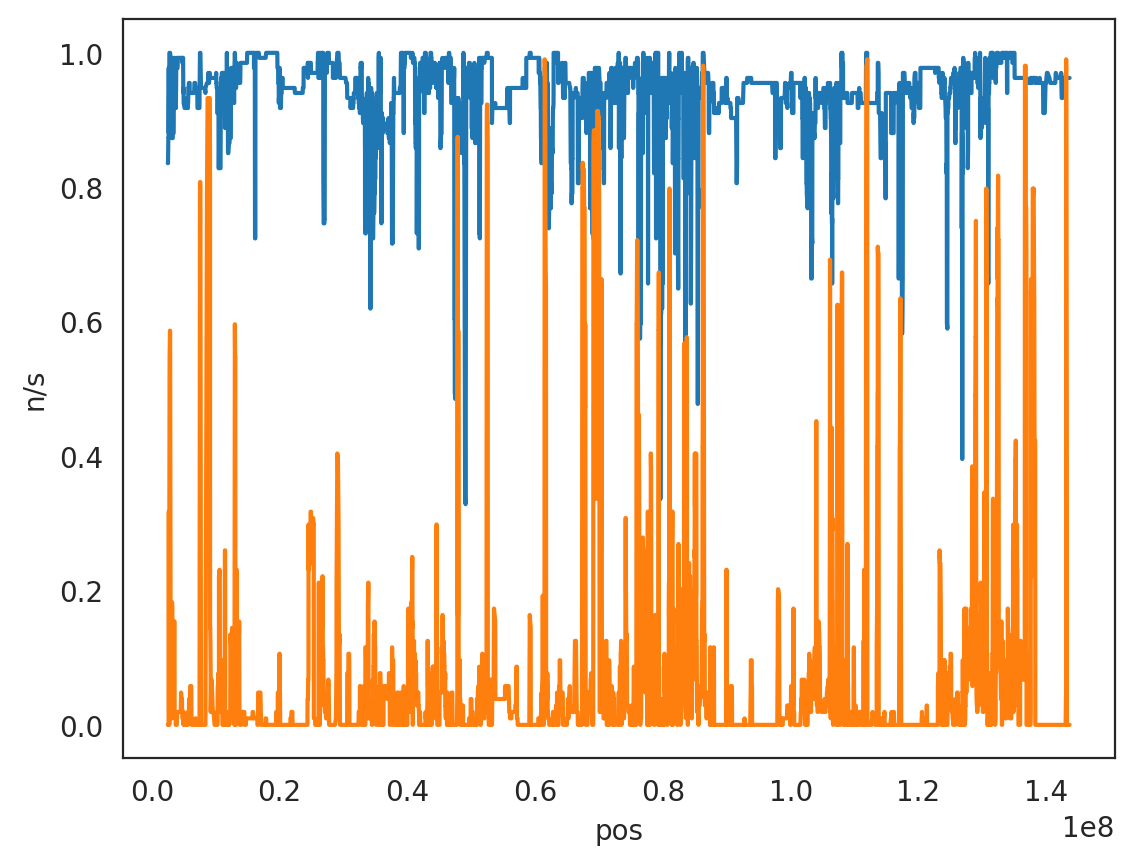

In [15]:
sns.lineplot(x = olive_tanzania.pos, y = olive_tanzania["n/s"])
sns.lineplot(x = eastern_yellow.pos, y = eastern_yellow["n/s"])
#sns.lineplot(x = western_yellow.pos, y = western_yellow["n/s"])

<Axes: xlabel='pos', ylabel='n/s'>

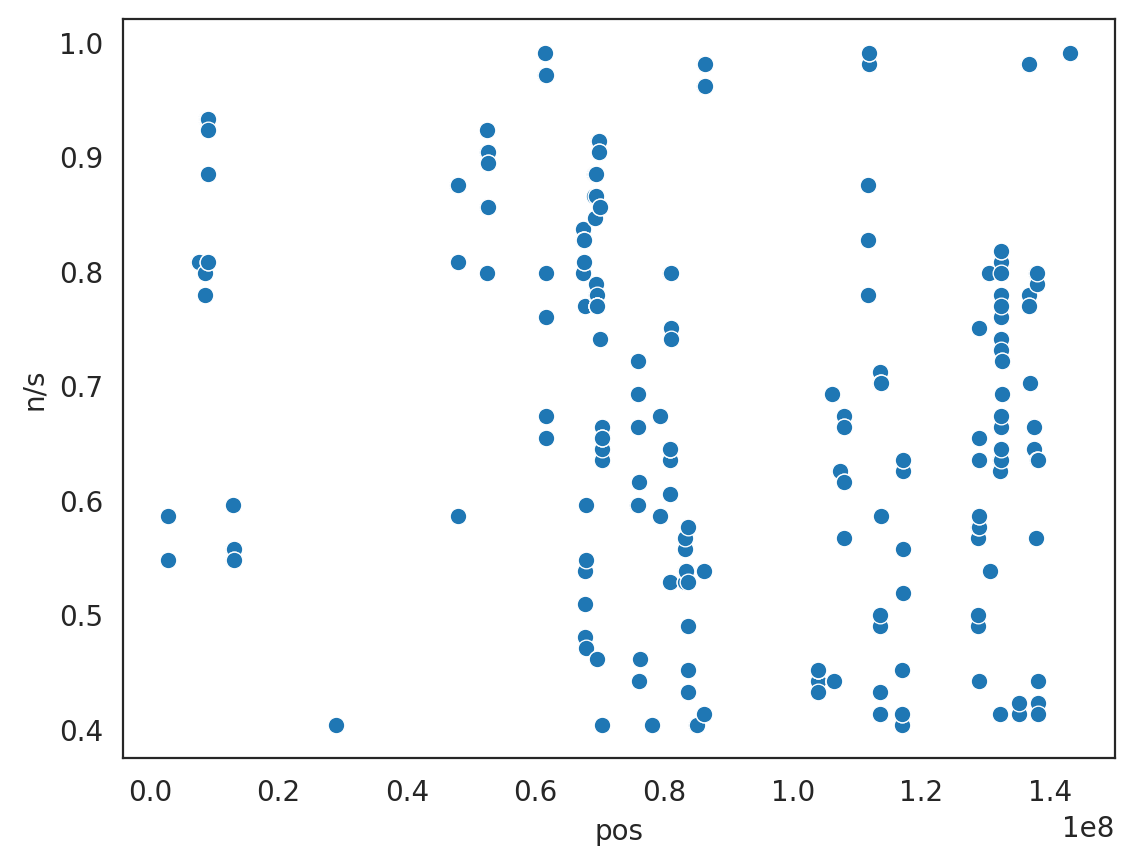

In [27]:
sub_eastern = eastern_yellow.loc[eastern_yellow["n/s"] > 0.4]
sns.scatterplot(data = sub_eastern, x="pos", y="n/s")

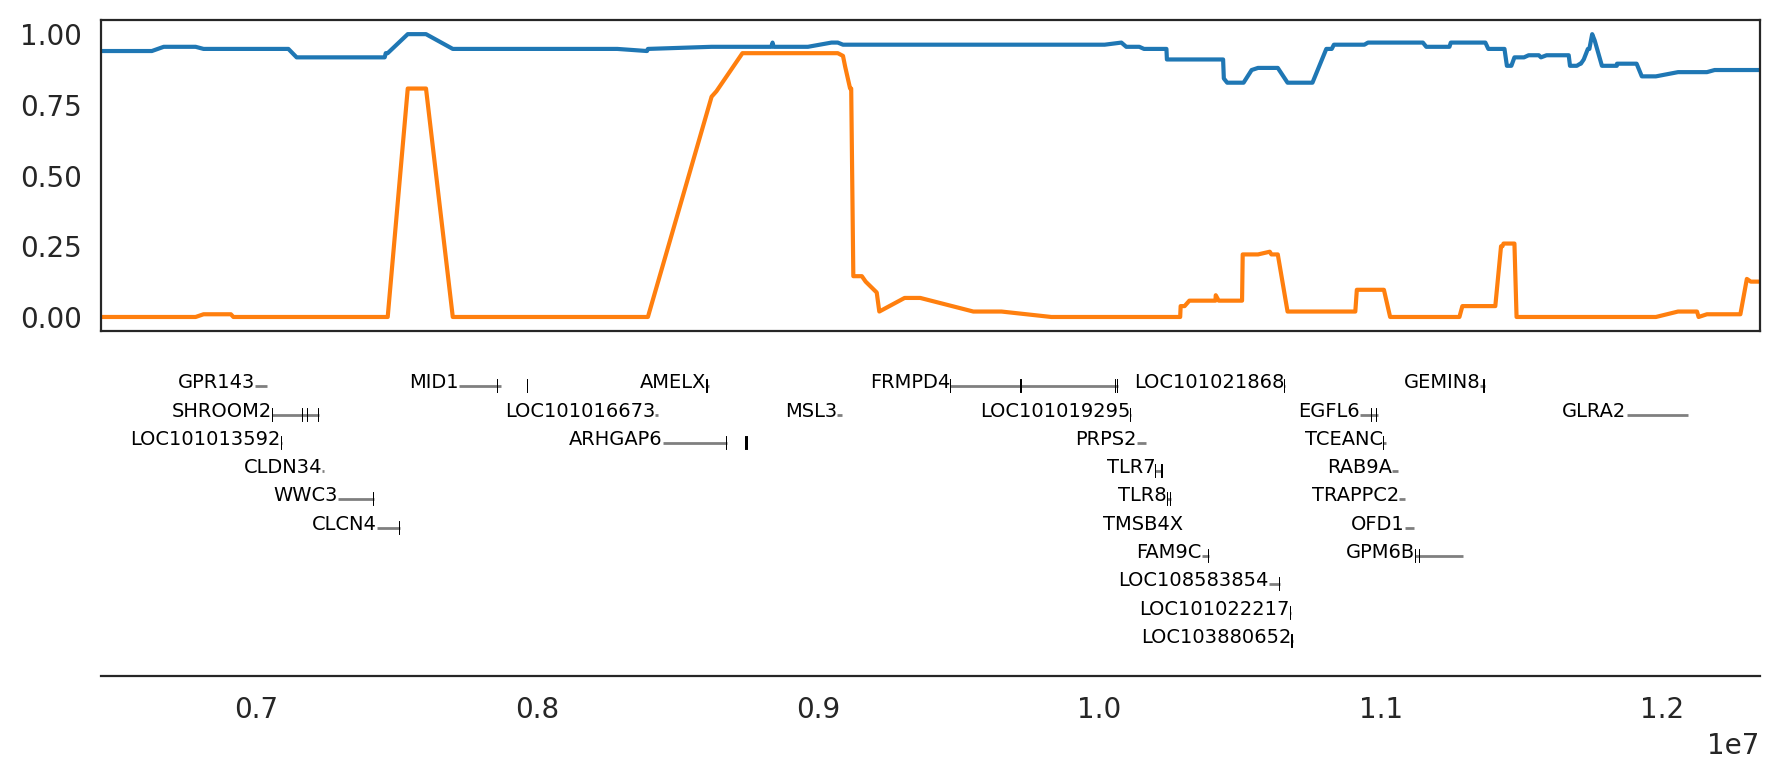

In [31]:
ax = gi.gene_plot('chrX', 7000000, 12000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

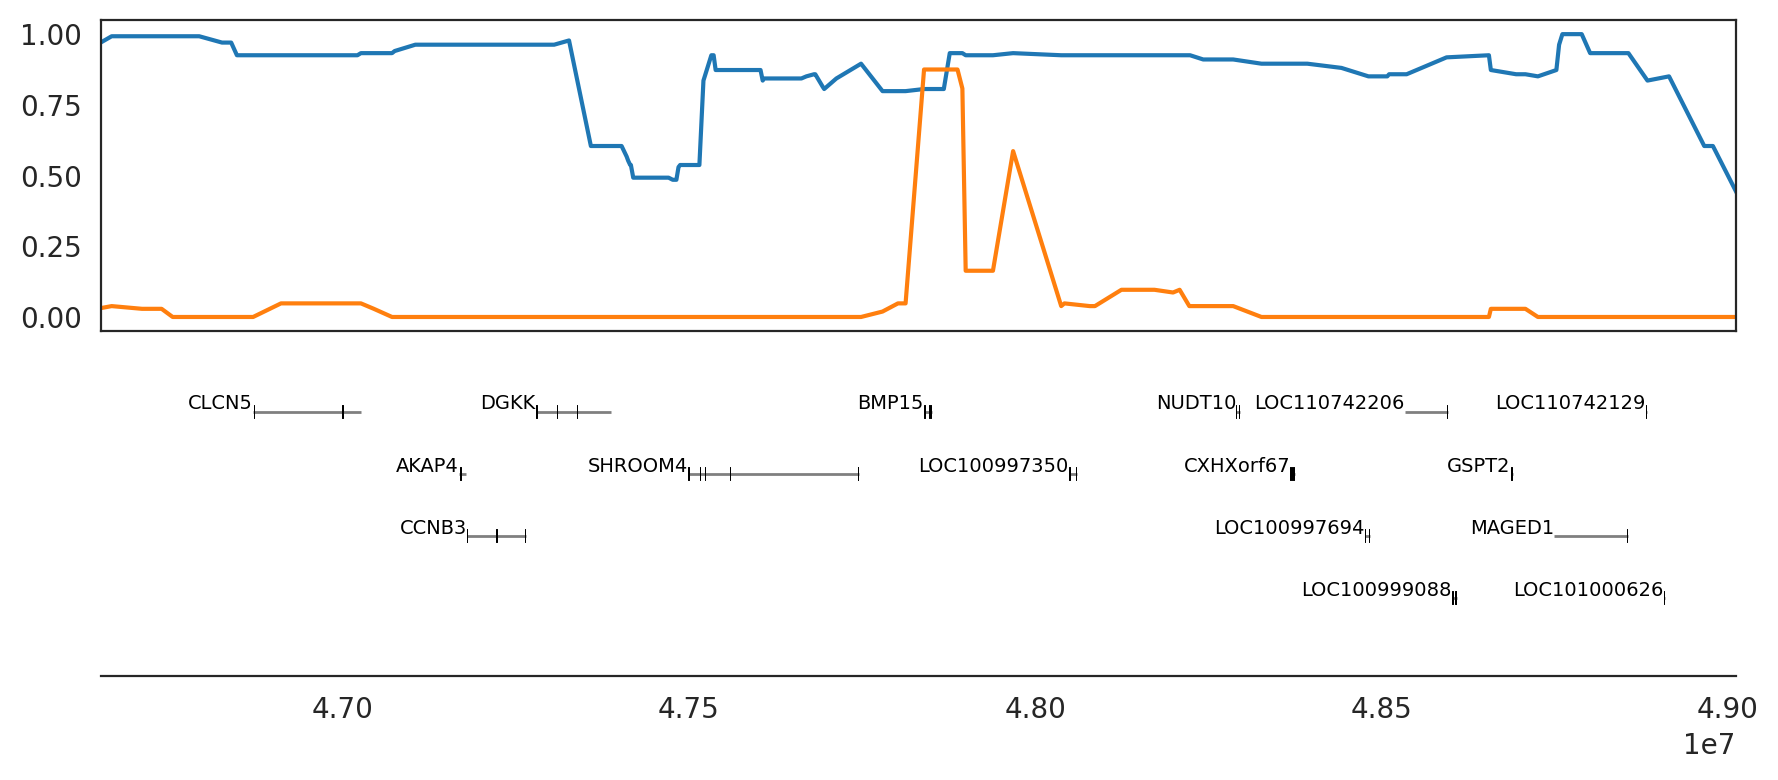

In [37]:
ax = gi.gene_plot('chrX', 47000000, 49000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

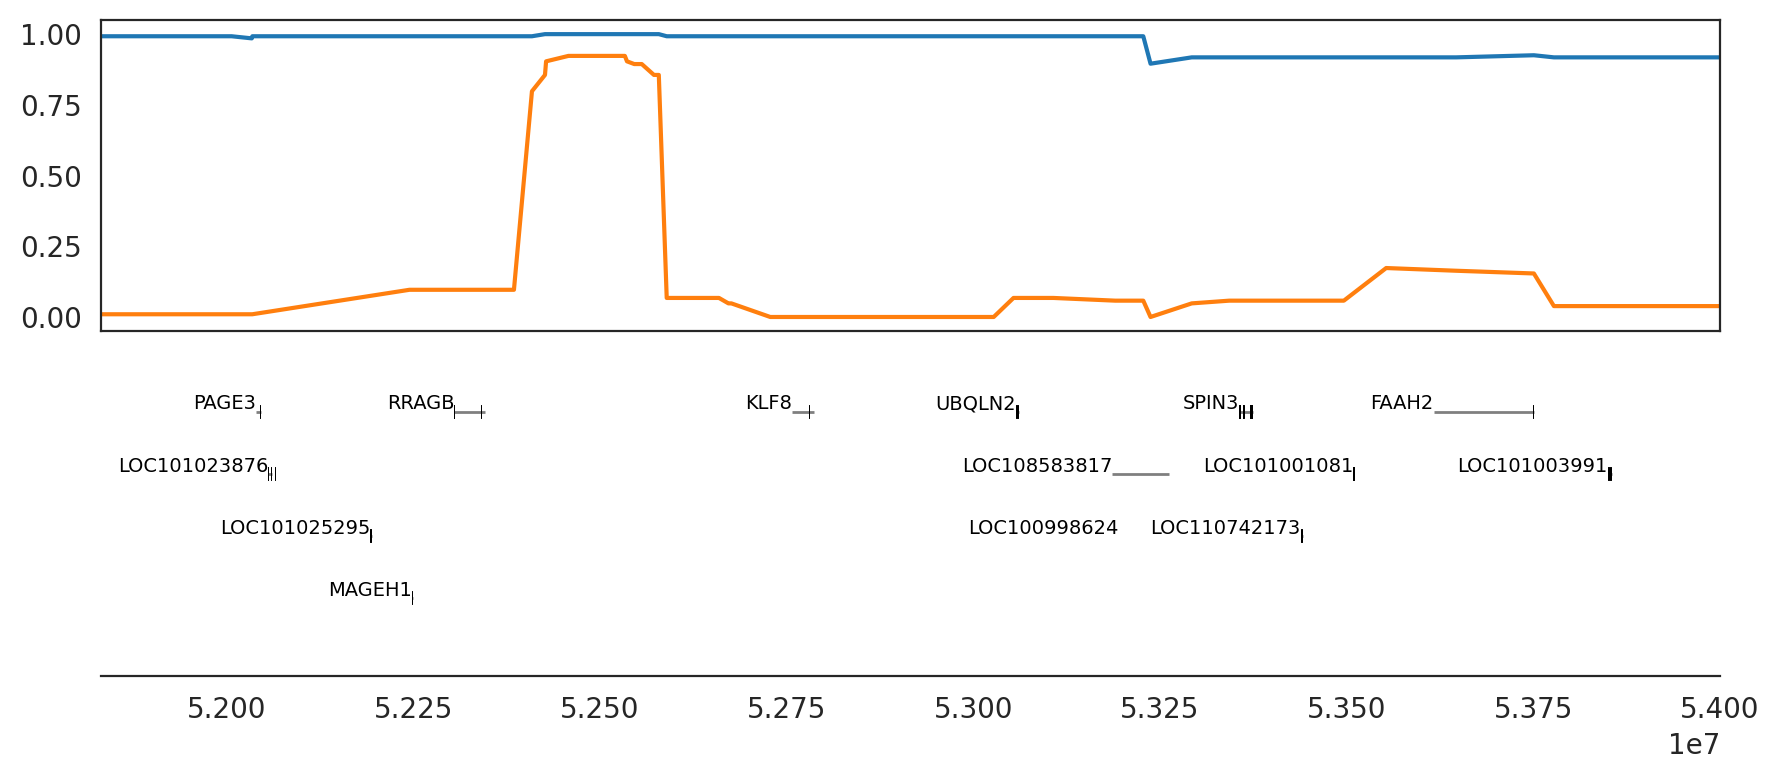

In [39]:
ax = gi.gene_plot('chrX', 52000000, 54000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

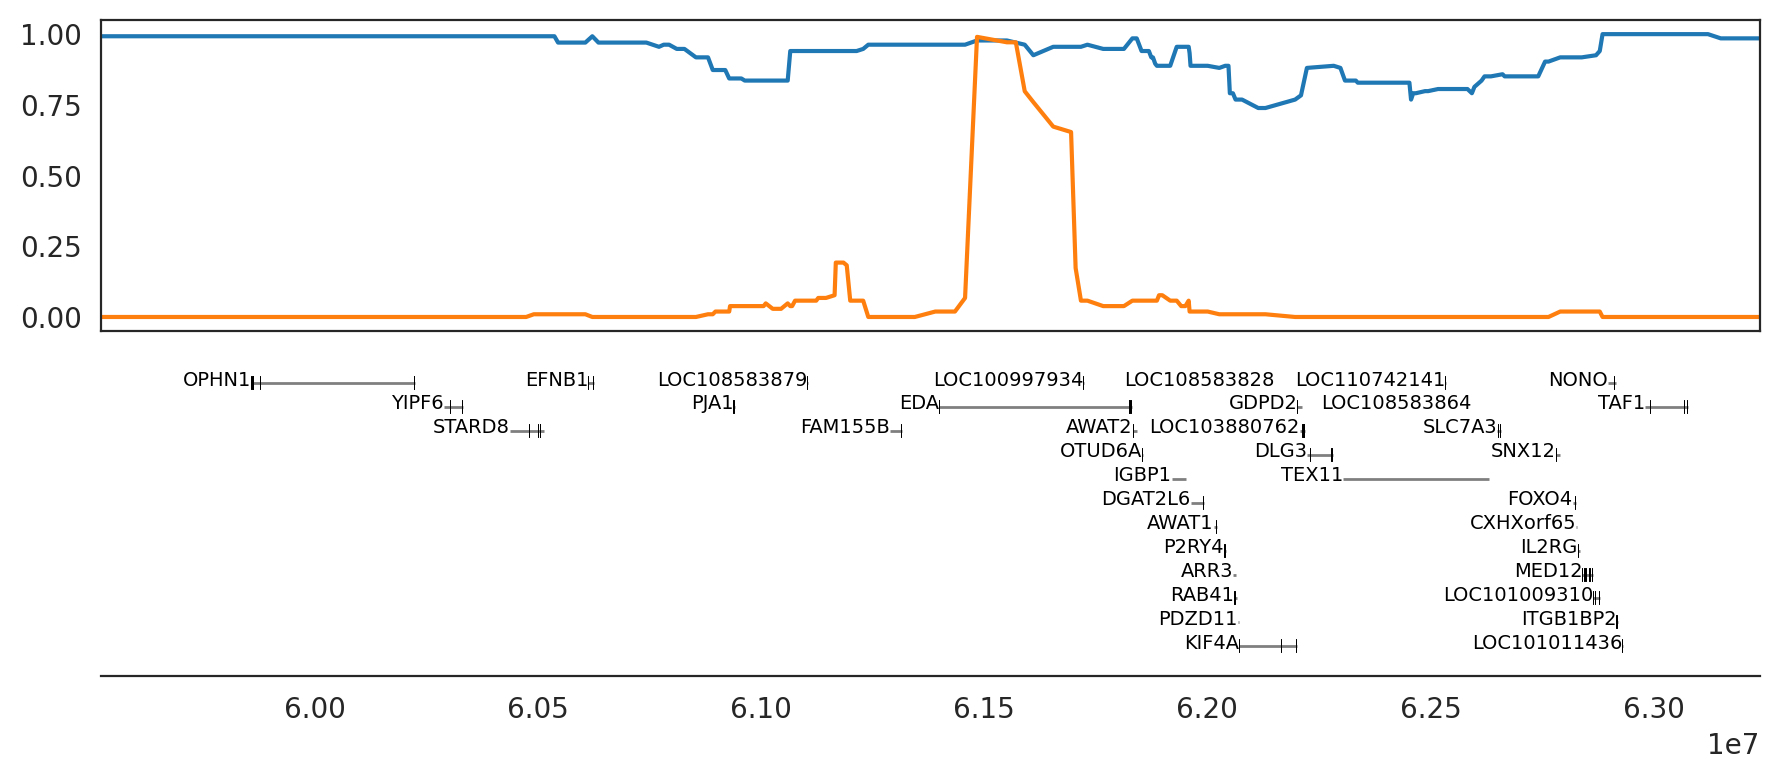

In [41]:
ax = gi.gene_plot('chrX', 60000000, 63000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

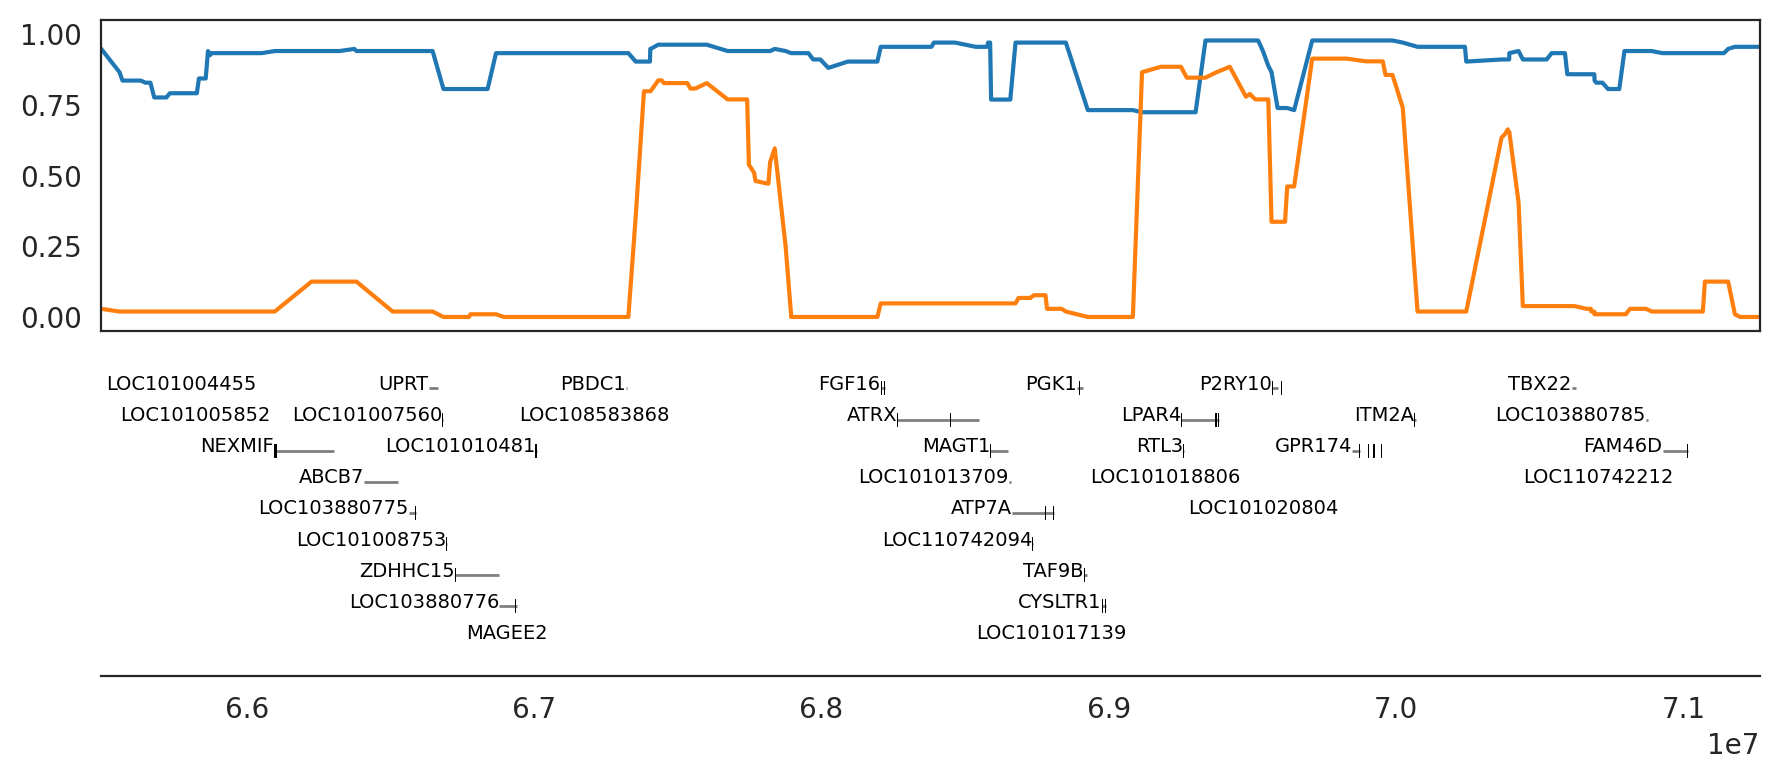

In [43]:
ax = gi.gene_plot('chrX', 66000000, 71000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

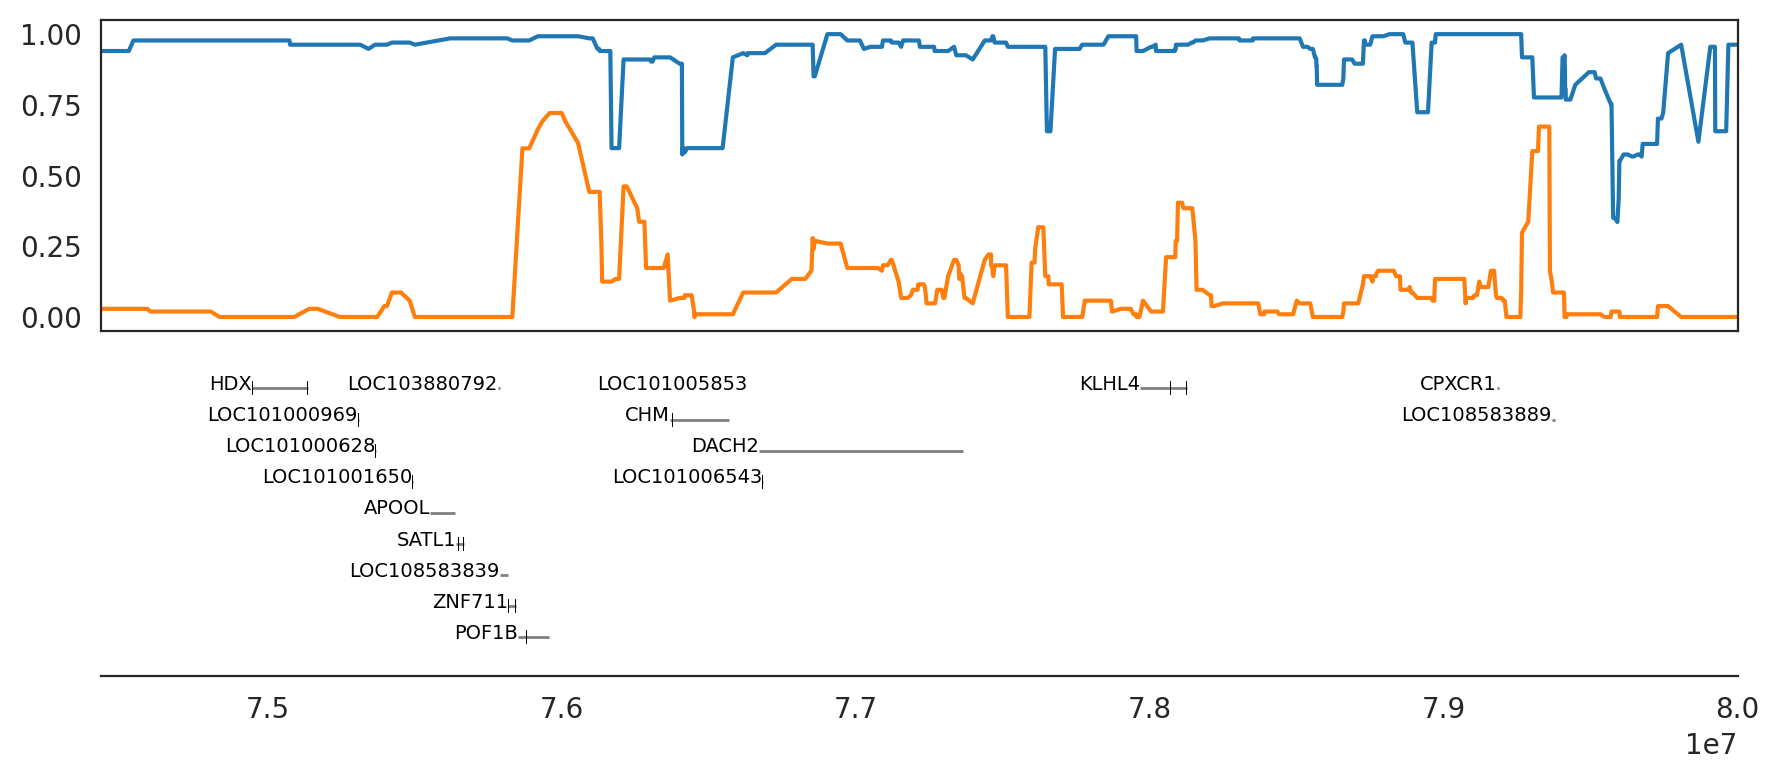

In [45]:
ax = gi.gene_plot('chrX', 75000000, 80000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

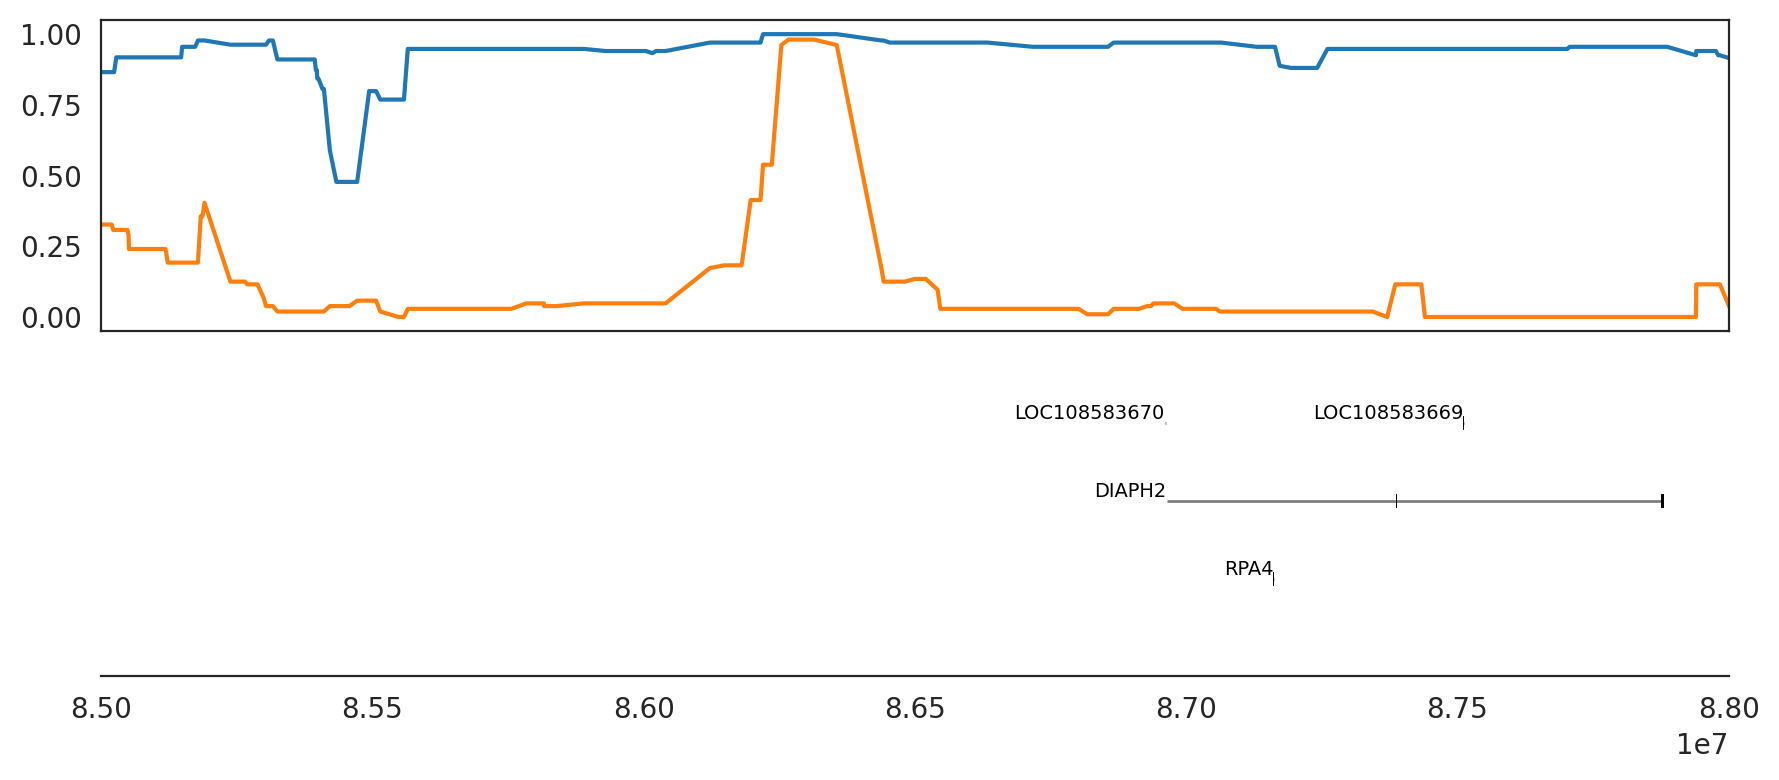

In [51]:
ax = gi.gene_plot('chrX', 85000000, 88000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

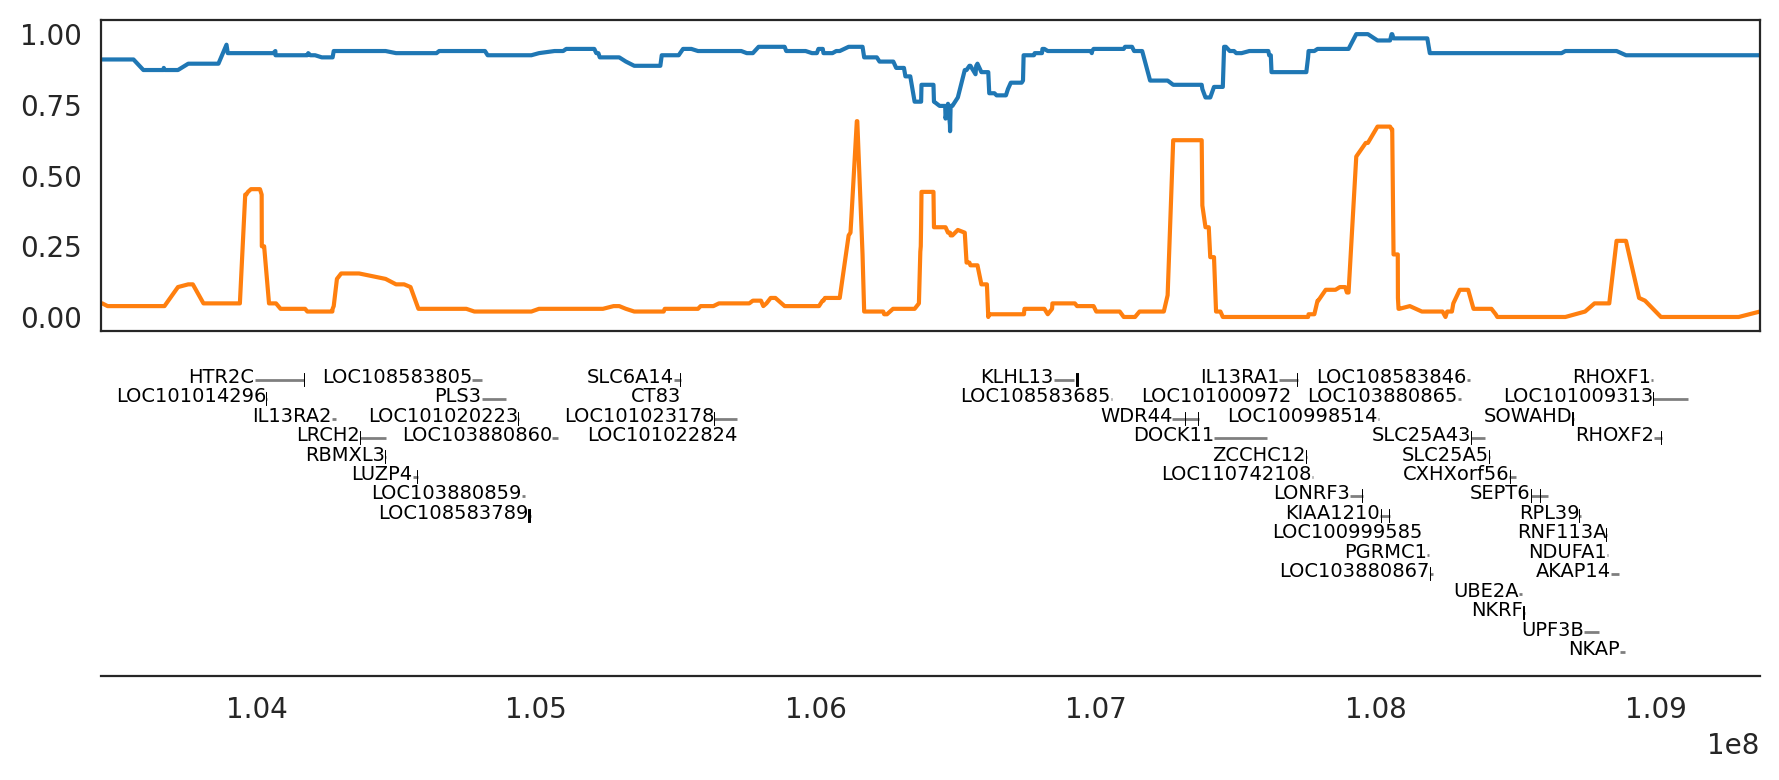

In [57]:
ax = gi.gene_plot('chrX', 104000000, 109000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

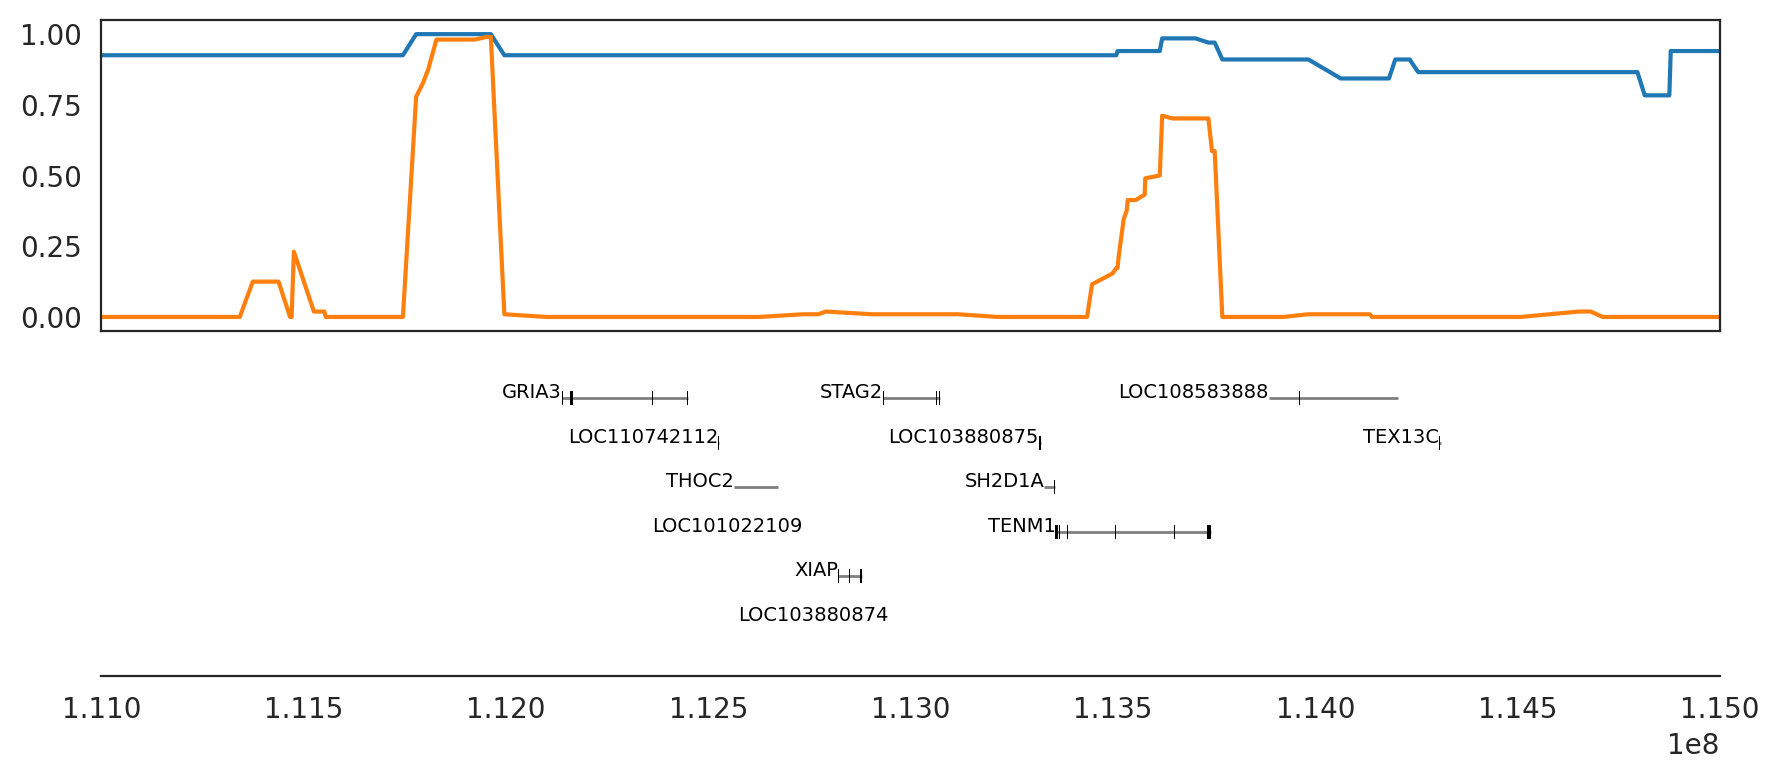

In [65]:
ax = gi.gene_plot('chrX', 111000000, 115000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

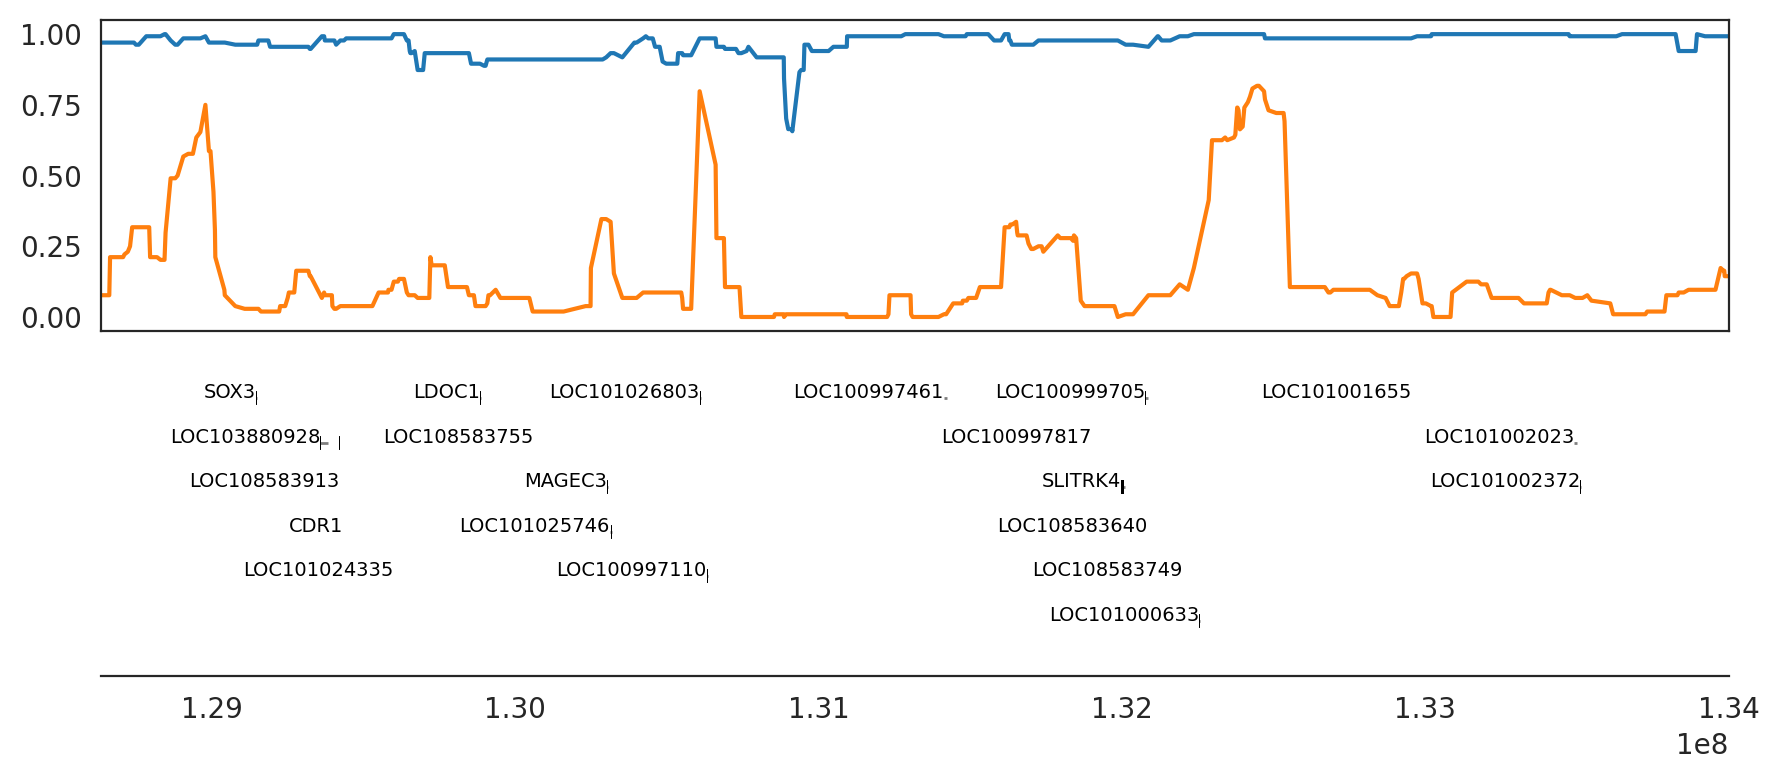

In [74]:
ax = gi.gene_plot('chrX', 129000000, 134000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

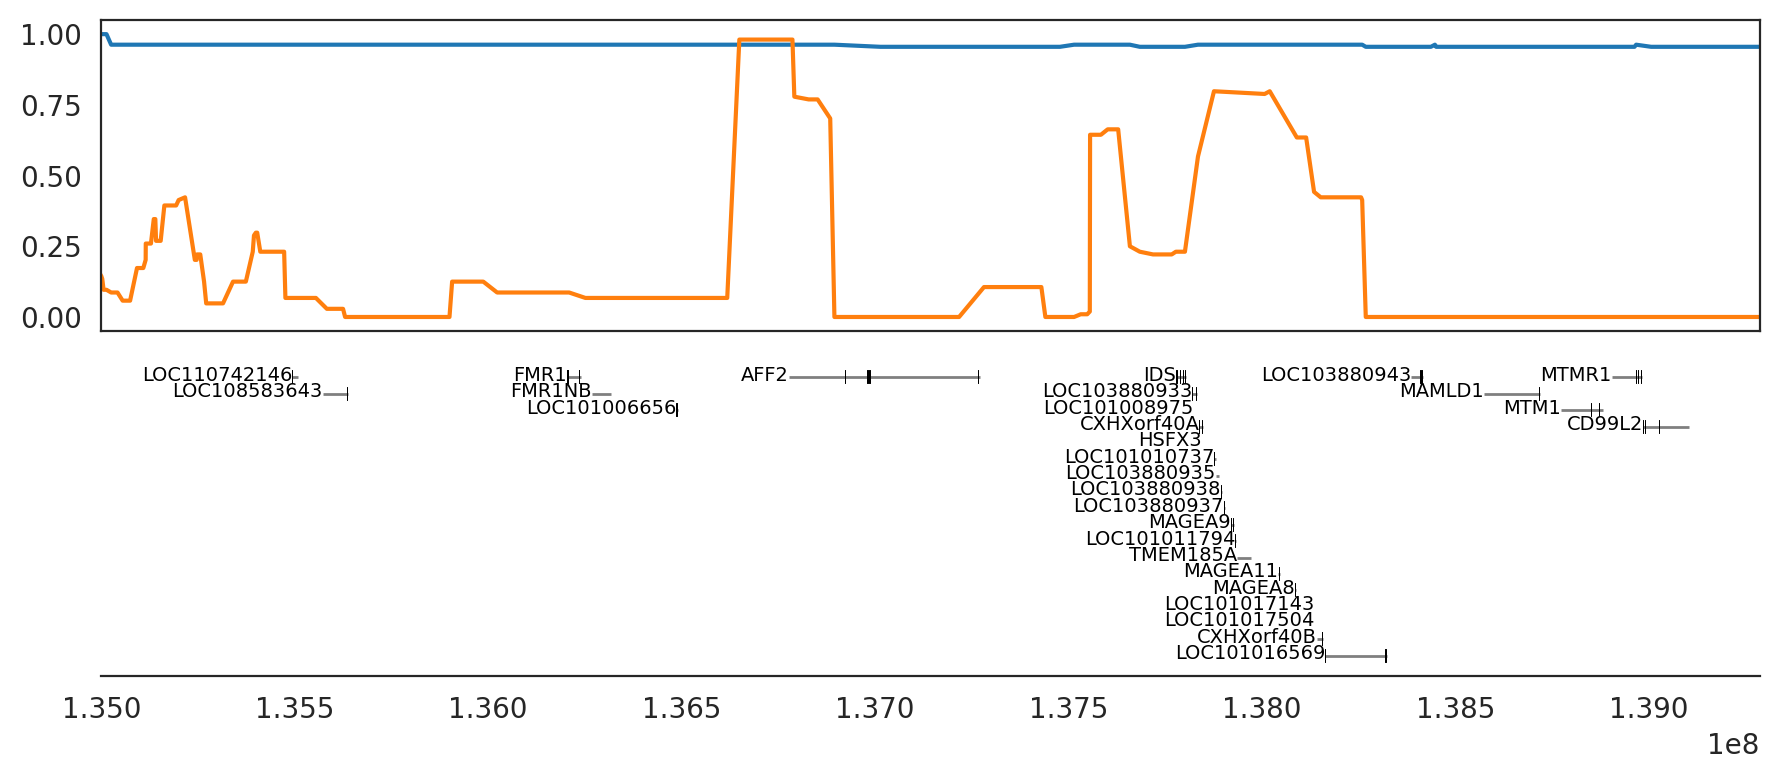

In [76]:
ax = gi.gene_plot('chrX', 135000000, 139000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

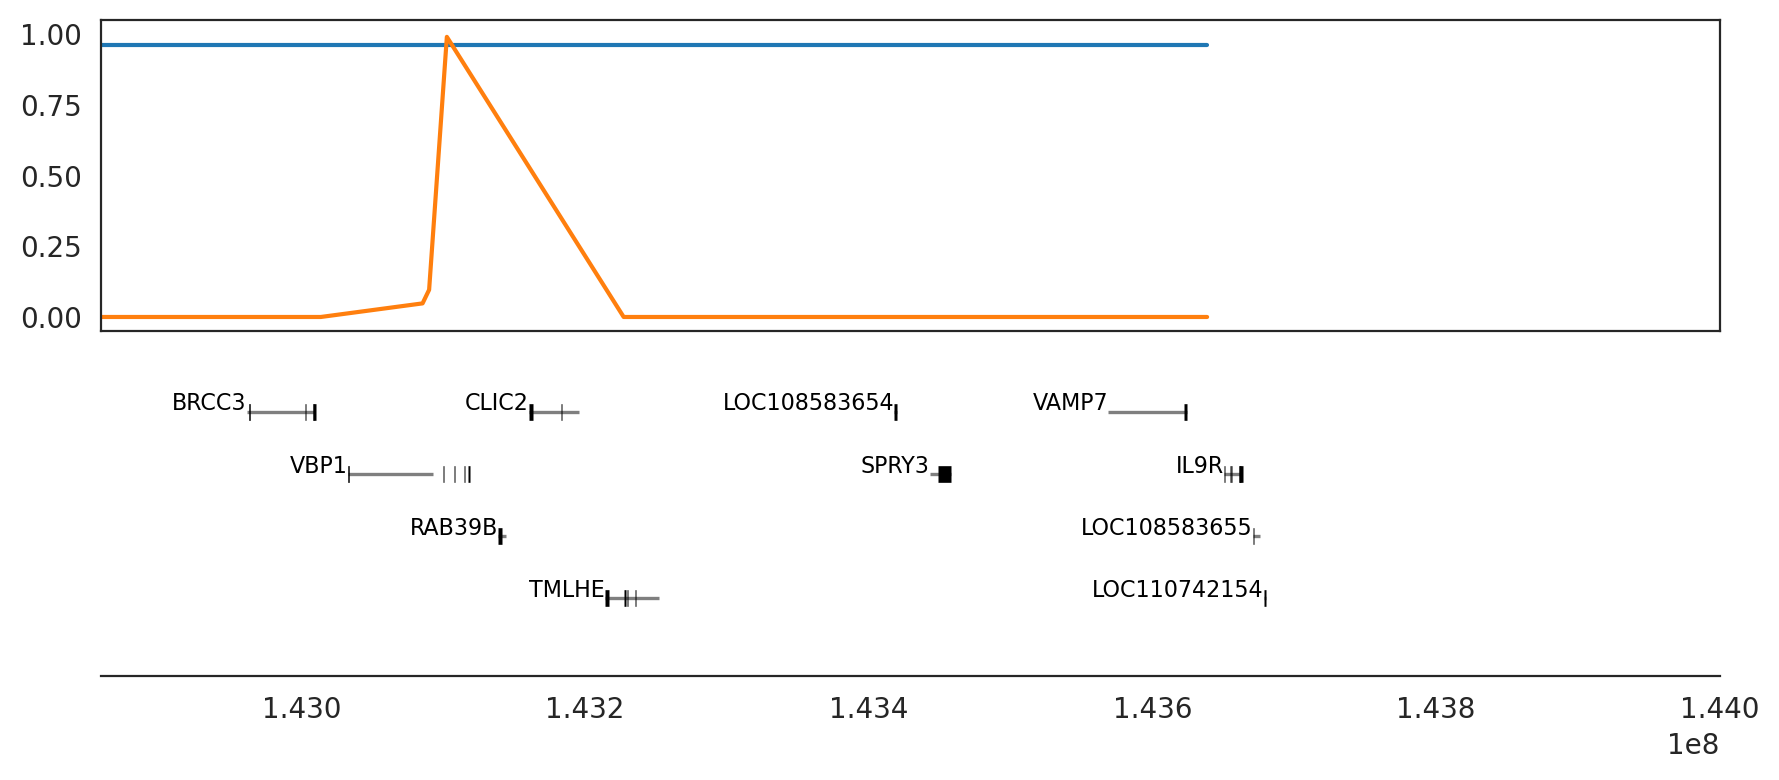

In [80]:
ax = gi.gene_plot('chrX', 143000000, 144000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

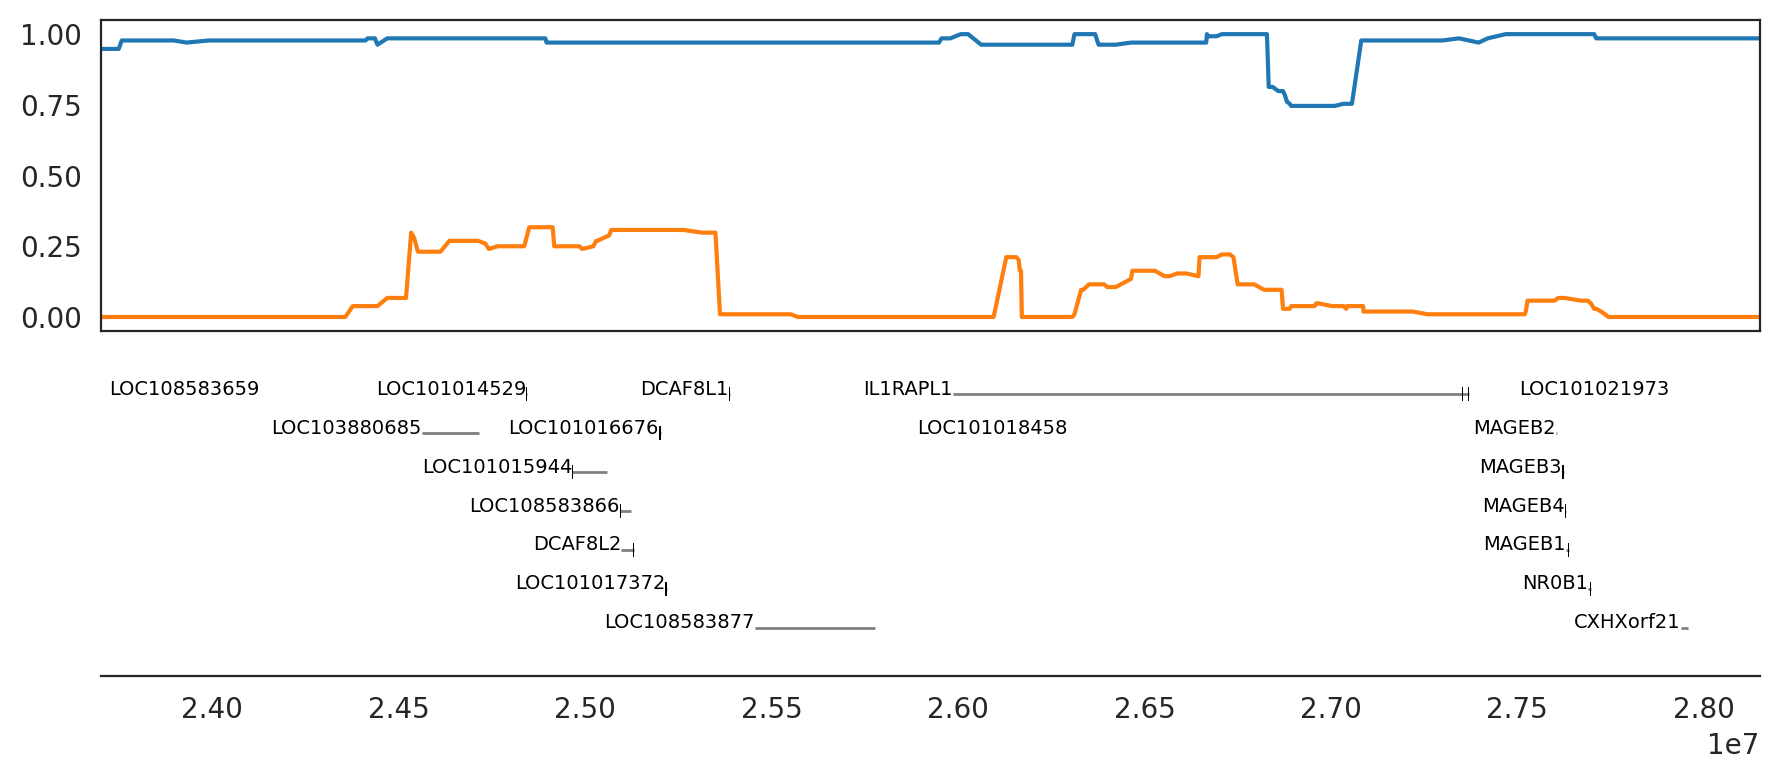

In [20]:
ax = gi.gene_plot('chrX', 24000000, 28000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

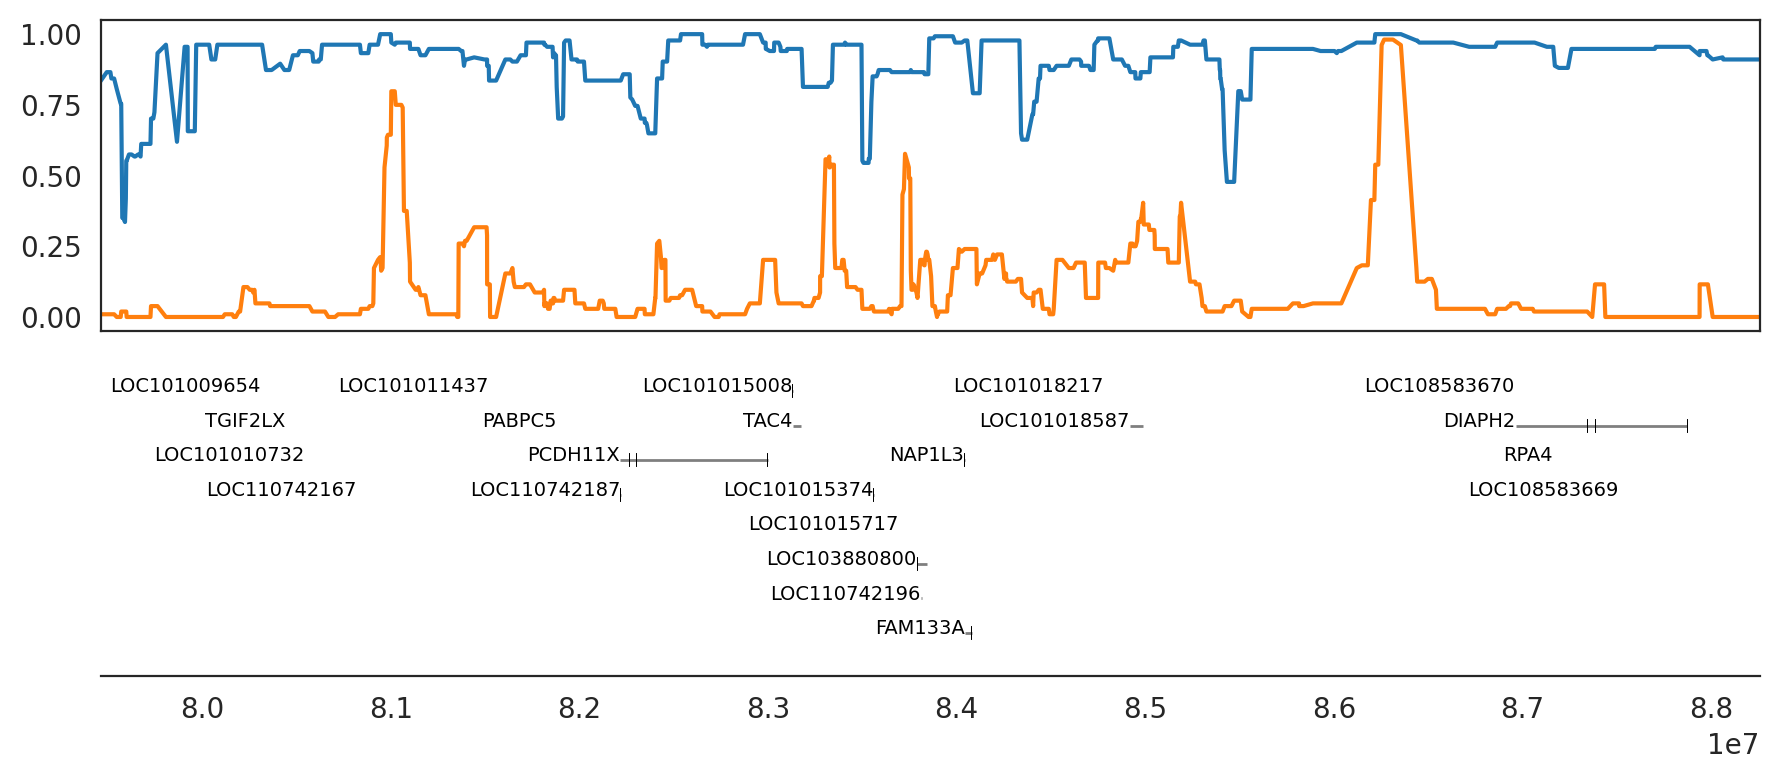

In [21]:
ax = gi.gene_plot('chrX', 80000000, 88000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

In [64]:
from scipy import stats
stats.spearmanr(olive_tanzania["n/s"], 1-eastern_yellow["n/s"])

SignificanceResult(statistic=-0.11460615215938336, pvalue=9.744630283573109e-23)

In [65]:
1-eastern_yellow["n/s"]

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
7283    0.951923
7284    0.903846
7285    0.009615
7286    1.000000
7287    1.000000
Name: n/s, Length: 7288, dtype: float64

In [63]:
stats.spearmanr([-1, -1, 1], [1, 1, -1])

SignificanceResult(statistic=-1.0, pvalue=0.0)

<Axes: xlabel='n/s', ylabel='Count'>

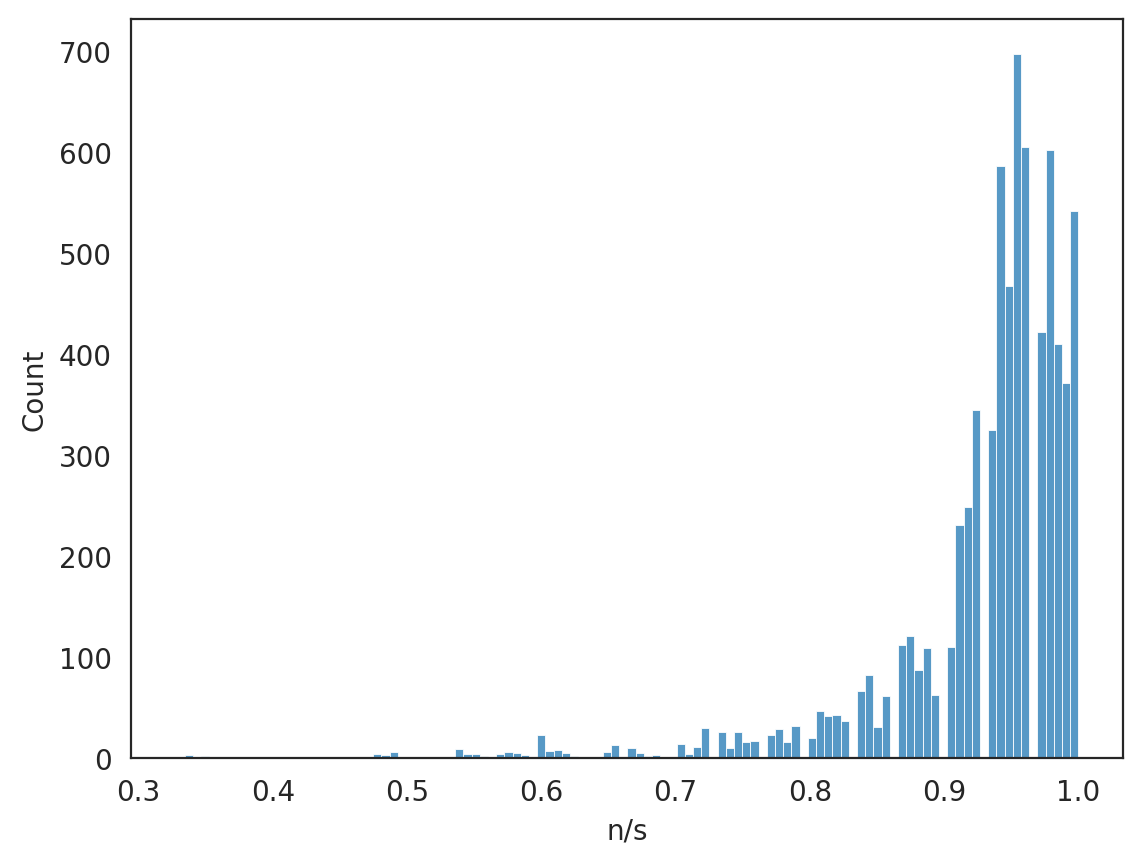

In [58]:
sns.histplot(x=olive_tanzania["n/s"])

[Text(0.5, 0, 'Yellow Major Parent Ancestry'),
 Text(0, 0.5, 'Olive Major Parent Ancestry')]

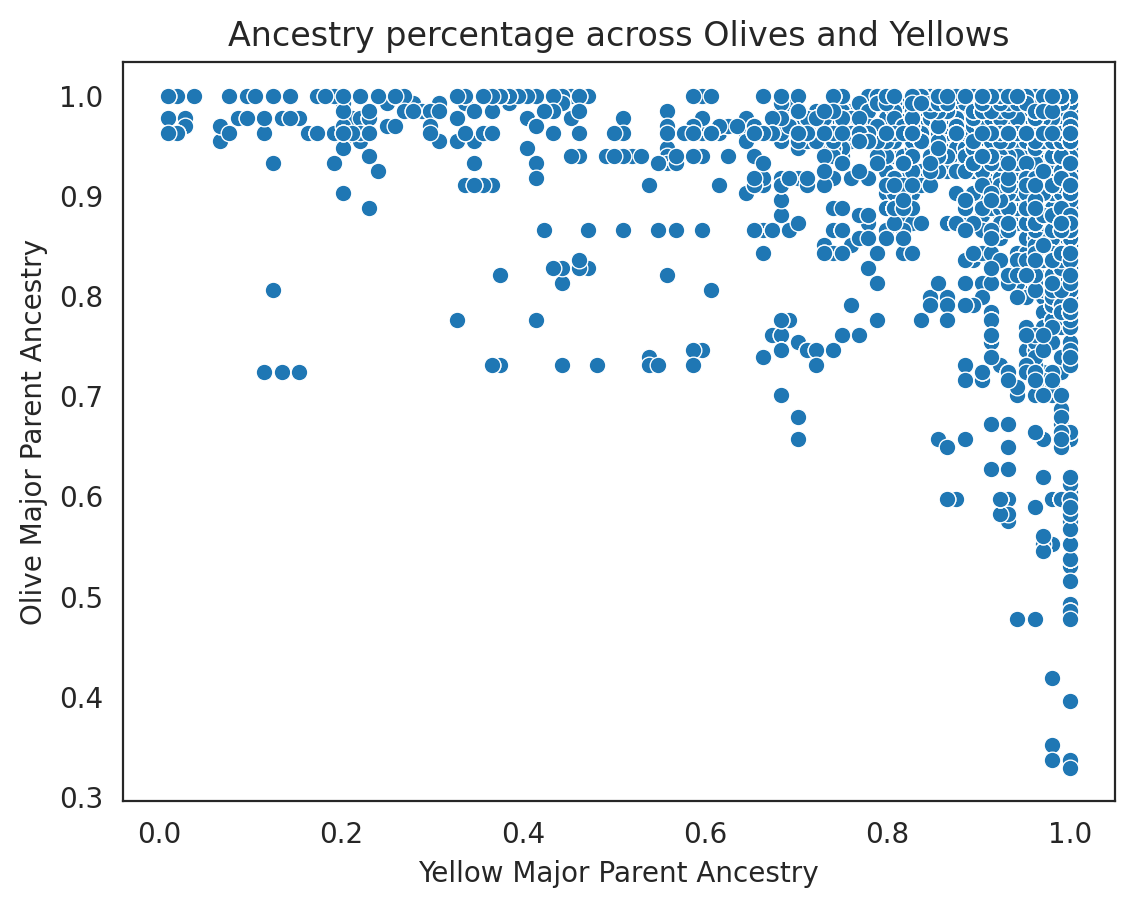

In [67]:
g = sns.scatterplot(y=olive_tanzania["n/s"], x=1-eastern_yellow["n/s"])
g.set(title="Ancestry percentage across Olives and Yellows")
g.set(xlabel="Yellow Major Parent Ancestry", ylabel="Olive Major Parent Ancestry")

Autosomes

In [20]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_all/"

In [21]:
input_file = rfmix_path + "chr14.msp.tsv"
chr14 = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [22]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [23]:
df_l = []
for hap in chr14.columns[6:]:
    df_l.append(create_paint_df_ind(chr14, hap, number_subpop_mapping, north_south_mapping))
length_df_14 = pd.concat(df_l)

In [24]:
sampling_locations_c = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].C_origin.unique()
sampling_locations_o = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].Origin.unique()


In [25]:
location_l = []
for sampling_location in sampling_locations_o:
    samples = meta_data_samples.loc[(meta_data_samples.Origin == sampling_location)].PGDP_ID
    s_df = length_df_14.loc[length_df_14.individual.isin(samples)]
    s_df = s_df.groupby("pos").mean().reset_index()
    s_df["Origin"] = sampling_location
    #s_df["C_origin"] = sampling_locations_c
    
    location_l.append(s_df)
location_df_14 = pd.concat(location_l)

In [27]:
loc_df = location_df_14

#olive_tanzania = loc_df.loc[loc_df.Origin == "Anubis, Tanzania"]
#eastern_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Central Tanzania"]
#western_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Western Tanzania"]

serengeti = loc_df.loc[loc_df.Origin == "Serengeti, Tanzania"]
tarangire = loc_df.loc[loc_df.Origin == "Tarangire, Tanzania"]
gog = loc_df.loc[loc_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = loc_df.loc[loc_df.Origin == "Gombe, Tanzania"]
mikumi = loc_df.loc[loc_df.Origin == "Mikumi, Tanzania"]
ruaha = loc_df.loc[loc_df.Origin == "Ruaha, Tanzania"]
mahale = loc_df.loc[loc_df.Origin == "Mahale, Tanzania"]
issa = loc_df.loc[loc_df.Origin == "Issa Valley, Tanzania"]
manyara = loc_df.loc[loc_df.Origin == "Lake Manyara, Tanzania"]
katavi = loc_df.loc[loc_df.Origin == "Katavi, Tanzania"]

/home/eriks/miniconda3/envs/geneinfo/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eriks/miniconda3/envs/geneinfo/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pos', ylabel='n/s'>

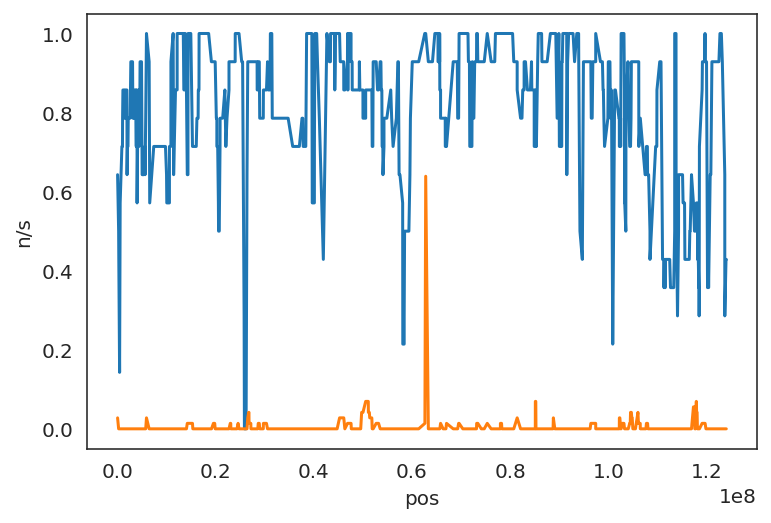

In [29]:
sns.lineplot(tarangire.pos, tarangire["n/s"])
sns.lineplot(mikumi.pos, mikumi["n/s"])
